# Data Augmentation Strategy

Numerous data augmentation strategies could be taken here, to list a couple:
- One of the most simple ones would be to add noise over the signal. However, the number of local peaks and overall signal length appeared to be useful features for distinguishing between classes and could be obscured by adding noise. The signal also appeared quite clean, so adding noise may cause differences between the training dataset and test dataset/real-world data. 
- Shifting the data could be a simple option, however because the signal length appeared to be a useful feature, this may also not be ideal.

The augmentation strategy I think will work well is a simple grafting technique where signals are split on a random point and combined. In this way, new signals will be made from two separate signals of the same class. While it may occasionally come up with unrealistic cases, overall this method should preserve the defining characteristics of each class.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import pywt

from pathlib import Path

np.random.seed(42)
random.seed(42)

data_folder = Path('../data/raw')

mitbih_train_df = pd.read_csv(data_folder / "mitbih_train.csv", header=None)

figure_directory = Path('../docs/assets/images/')

## Grafting Augmentation

In [70]:

def graft_signals(signal1, signal2):
    """Combines two signals at a random point to generate a new signal"""
    split_point = random.randint(0, len(signal1) - 1)
    return np.concatenate([signal1[:split_point], signal2[split_point:]])


def temporal_shift_signal(signal, max=10):
    """Applies a random shift along the x-axis"""
    s = pd.Series(signal)
    shift = random.randint(-max, max)
    s = s.shift(shift).ffill().bfill()
    return s.values


def amplitude_shift_signal(signal, max=0.1):
    """Applies a random shift along the y-axis"""
    signal = signal + random.random() * max * 2 - max
    return np.clip(signal, 0, 1)


def add_noise(signal, scale=0.05):
    """Applies multiplicative noise generated using a normal distribution"""
    noise = np.random.normal(loc=1.0, scale=scale, size=len(signal))
    signal = signal * noise

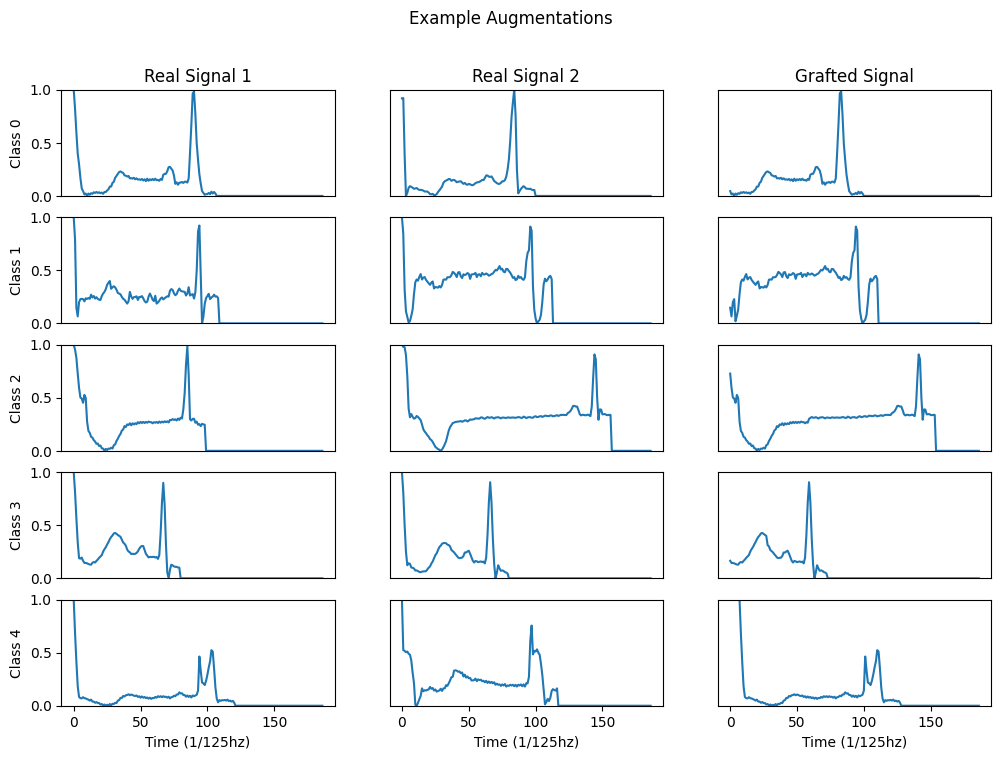

In [71]:
np.random.seed(101)

# The last column is the class
mitbih_train_df = mitbih_train_df.rename(columns={mitbih_train_df.columns[-1]:'class'})
mitbih_train_df['class'] = mitbih_train_df['class'].astype(int)

plt.figure(figsize=(12,8))
gs = plt.GridSpec(5, 3)

for i, (c, class_df) in enumerate(mitbih_train_df.groupby('class')):
    # Plot normal examples and augmented ones side by side
    
    signal1 = class_df.sample(1).iloc[0].values[:-1]
    signal2 = class_df.sample(1).iloc[0].values[:-1]
    signal = graft_signals(signal1, signal2)
    signal = temporal_shift_signal(signal)
    
    # Plot a normal sample
    plt.subplot(gs[i,0])
    plt.plot(signal1)
    plt.ylim([0,1])
    plt.ylabel(f"Class {i}")
    plt.gca().axes.get_xaxis().set_visible(False)

    plt.subplot(gs[i,1])
    plt.plot(signal2)
    plt.ylim([0,1])
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)

    plt.subplot(gs[i,2])
    plt.plot(signal)
    plt.ylim([0,1])
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)

plt.subplot(gs[0])
plt.title("Real Signal 1")
plt.subplot(gs[1])
plt.title("Real Signal 2")
plt.subplot(gs[2])
plt.title("Grafted Signal")

plt.subplot(gs[-1,0])
plt.gca().axes.get_xaxis().set_visible(True)
plt.xlabel("Time (1/125hz)")

plt.subplot(gs[-1,1])
plt.gca().axes.get_xaxis().set_visible(True)
plt.xlabel("Time (1/125hz)")

plt.subplot(gs[-1,2])
plt.gca().axes.get_xaxis().set_visible(True)
plt.xlabel("Time (1/125hz)")

plt.suptitle(f"Example Augmentations")
plt.savefig(figure_directory / f"example_augmentations.png")
# plt.tight_layout(pad=0.5)
plt.show()

## Wavelet Transform Example

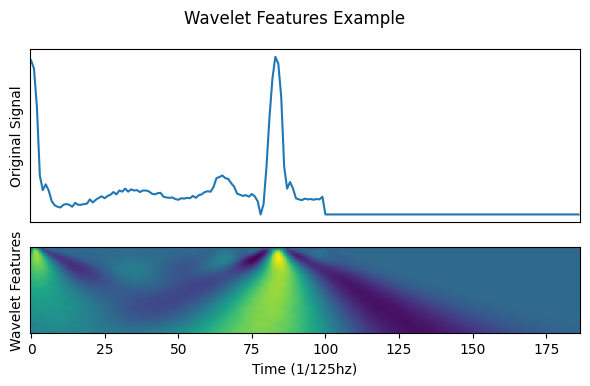

In [63]:
data = mitbih_train_df.iloc[0,:-1].values
cwtmatr, freqs = pywt.cwt(data, np.arange(1,30), 'mexh')

plt.figure(figsize=(6, 4))
gs = plt.GridSpec(2, 1)
plt.suptitle("Wavelet Features Example")

ax = plt.subplot(gs[1])
plt.imshow(cwtmatr)
plt.xlabel("Time (1/125hz)")
plt.yticks([])
plt.ylabel('Wavelet Features')

plt.subplot(gs[0], sharex=ax)
plt.gca().axes.get_xaxis().set_visible(False)
plt.plot(data)
plt.yticks([])
plt.ylabel('Original Signal')

plt.tight_layout()
plt.savefig(figure_directory/'wavelet_features.png')
plt.show()
